In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [1]:
ab = '../../../lr_bulk/talon/human_talon_abundance.tsv'
cerberus_h5 = '../../../lr_bulk/cerberus/triplets/cerberus_annot_triplets.h5'
swan_file = '../../..//lr_bulk/cerberus/swan/swan_meta.p'

ver = 'v40_cerberus'

min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'dataset'

In [3]:
ca = cerberus.read(cerberus_h5)

In [4]:
sg = swan.read(swan_file)

Read in graph from ../../..//lr_bulk/cerberus/swan/swan_meta.p


In [5]:
# add library-level expressed triplets
df = ca.get_expressed_triplets(sg,
                               obs_col=obs_col,
                               min_tpm=min_tpm,
                               source='library_det')
ca.add_triplets(df)

In [7]:
# remove non-polya genes
df, _, _ = get_gtf_info(how='gene',
                        ver=ver,
                        subset=gene_subset)
df['gid_stable'] = cerberus.get_stable_gid(df, 'gid')
polya_gids = df.gid_stable.tolist()
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(polya_gids)]

In [8]:
ca.write('cerberus_ad.h5')

## Analysis

In [68]:
ca = cerberus.read('cerberus_ad.h5')

In [69]:
# limit triplets to just the brain ones
ca.triplets = ca.triplets.loc[~(ca.triplets.dataset.isnull())&\
                              (ca.triplets.dataset.str.contains('brodmann'))&\
                              (ca.triplets.source=='library_det')]

In [70]:
# merge in disease status
sg.adata.obs.health_status.unique()
sg.adata.obs.head()

,dataset,total_counts,sample,classification,health_status,file_id,sample_display
index,,,,,,,
h9_neural_crest_1_1,h9_neural_crest_1_1,648205.0,h9_neural_crest,cell_line,NaN,ENCFF319JFG,H9-derived neural crest
a673_1_1,a673_1_1,939118.0,a673,cell_line,NaN,ENCFF045ZQI,A673
h9_chondro_1_3,h9_chondro_1_3,1024055.0,h9_chondro,cell_line,NaN,ENCFF469ATL,H9-derived chondrocytes
hl60_m2_24hr_1_2,hl60_m2_24hr_1_2,751282.0,hl60_m2_24hr,cell_line,NaN,ENCFF832PKO,HL60-derived M2 macrophages 24 hr
h9_neural_crest_1_2,h9_neural_crest_1_2,867560.0,h9_neural_crest,cell_line,NaN,ENCFF901XCR,H9-derived neural crest


In [71]:
ca.triplets = ca.triplets.merge(sg.adata.obs[['health_status']],
                                how='left',
                                left_on='dataset',
                                right_index=True)

In [72]:
ca.triplets.health_status = ca.triplets.health_status.astype(str)

In [73]:
# get centroids for each health status
inds = ca.triplets.loc[ca.triplets.health_status == 'AD'].index
ca.triplets.loc[inds, 'source'] = 'library_ad_det'

inds = ca.triplets.loc[ca.triplets.health_status == 'healthy'].index
ca.triplets.loc[inds, 'source'] = 'library_healthy_det'

ca = get_centroids(ca,
                   source='library_ad_det',
                   gene_subset=gene_subset,
                   ver=ver)
ca = get_centroids(ca,
                   source='library_healthy_det',
                   gene_subset=gene_subset,
                   ver=ver)


df = compute_dists([ca,ca],
                   ['library_ad_det_centroid',
                    'library_healthy_det_centroid'],
                   rm_1_isos=[False,False],
                   ver=[ver,ver])

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [74]:
temp = df.loc[df.z_score>2, ['gname', 'z_score']].drop_duplicates()
temp.to_csv('ad_vs_healthy_centroid_z_score_2_genes.txt',index=False)
len(temp.index)
temp.head()

,gname,z_score
50,ABHD11,2.623324
55,ABHD14A-ACY1,2.405305
60,ABHD17B,2.242495
80,ABT1,2.081945
84,ACACA,3.588262


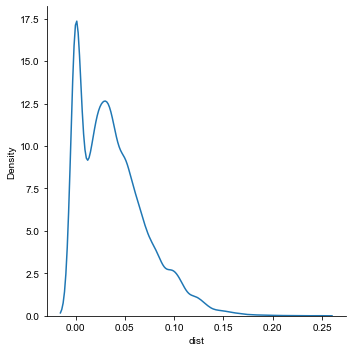

In [61]:
sns.displot(df, x='dist', kind='kde')

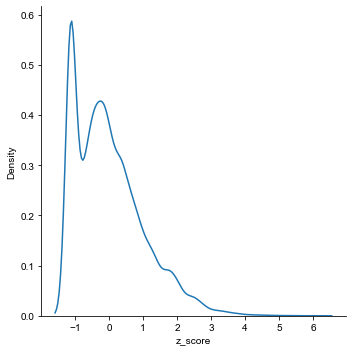

In [62]:
sns.displot(df, x='z_score', kind='kde')

In [65]:
# which genes are the farthest apart
df.sort_values(by='dist', ascending=False)[['gname', 'dist', 'z_score']].head(20)

,gname,dist,z_score
165,ACY1,0.244692,6.094950
1708,CDCA7L,0.225600,5.530727
3791,FLII,0.220568,5.382007
4323,GPS2,0.210958,5.098003
12024,ZFYVE19,0.208591,5.028060
10844,TMEM218,0.199577,4.761650
12387,ZNF76,0.199457,4.758111
10011,SPIDR,0.197837,4.710227
5934,MCUR1,0.194321,4.606329
1160,C11orf71,0.192823,4.562067


In [40]:
c_dict, order = get_ad_colors()
mmap = {'library_ad_det_centroid': 'x',
        'library_healthy_det_centroid': 'x'}

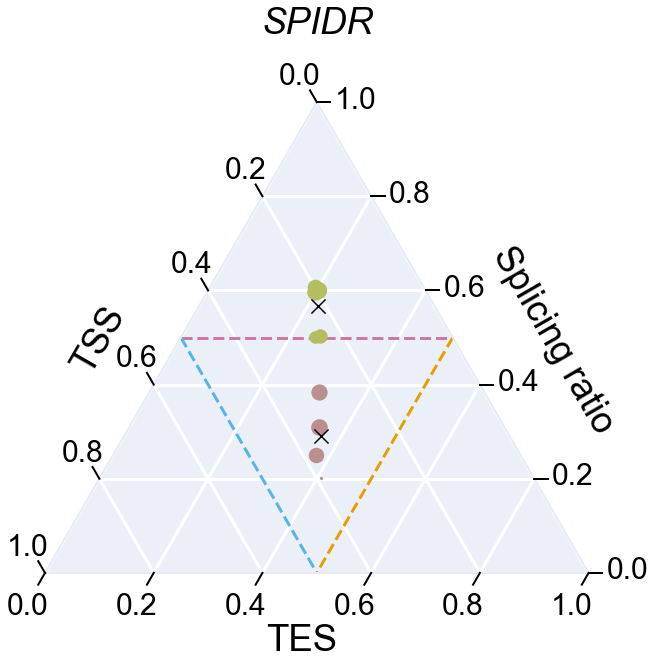

In [66]:
df = ca.plot_simplex(top='splicing_ratio', 
            gene='SPIDR',
            hue='health_status',
            cmap=c_dict,
            size='gene_tpm',
            mmap=mmap,
            marker_style='source',
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=1)

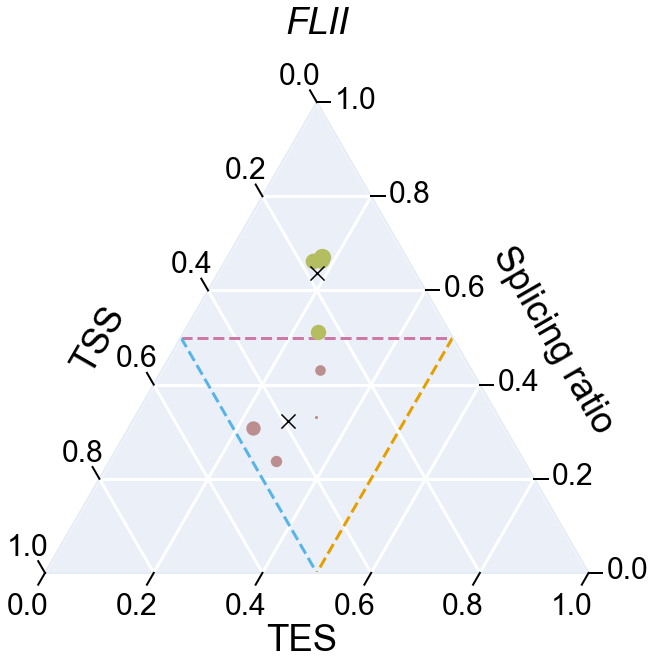

In [44]:
df = ca.plot_simplex(top='splicing_ratio', 
            gene='FLII',
            hue='health_status',
            cmap=c_dict,
            size='gene_tpm',
            mmap=mmap,
            marker_style='source',
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=1)

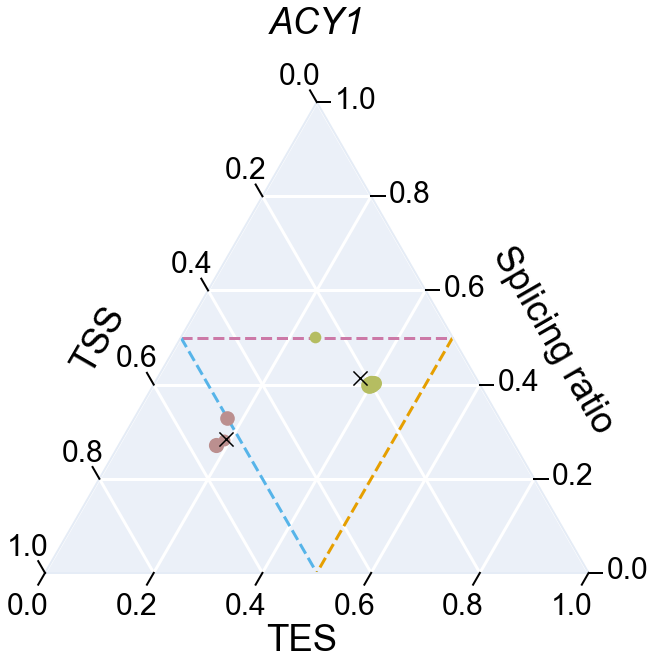

In [41]:
df = ca.plot_simplex(top='splicing_ratio', 
            gene='ACY1',
            hue='health_status',
            cmap=c_dict,
            size='gene_tpm',
            mmap=mmap,
            marker_style='source',
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=1)

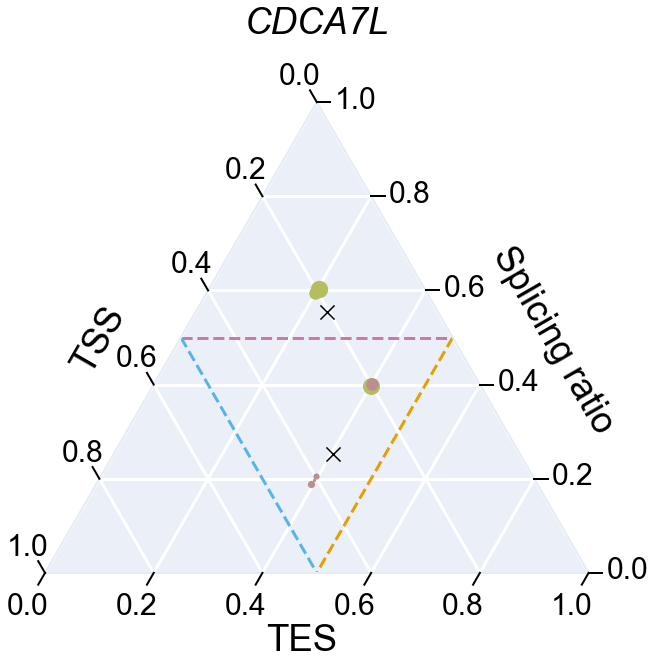

In [43]:
df = ca.plot_simplex(top='splicing_ratio', 
            gene='CDCA7L',
            hue='health_status',
            cmap=c_dict,
            size='gene_tpm',
            mmap=mmap,
            marker_style='source',
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=1)

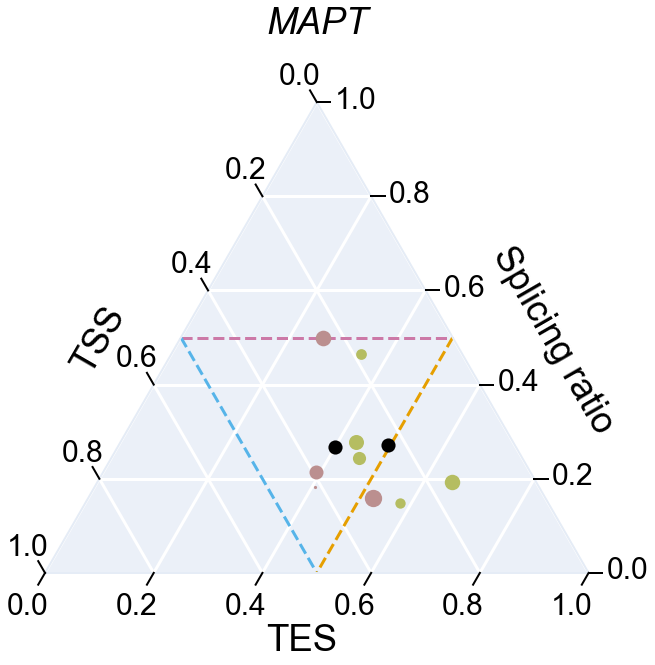

In [42]:
c_dict, order = get_ad_colors()
df = ca.plot_simplex(top='splicing_ratio', 
            gene='MAPT',
            hue='health_status',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=1)

## What about predominant isoform switches? 

In [5]:
def get_exp_gene_subset(ab, min_tpm, obs_col):
    df = pd.read_csv(ab, sep='\t')
    if obs_col == 'dataset':
        gb = 'library'
    else:
        gb = obs_col
    df = get_det_table(df,
                  groupby=gb,
                  how='gene',
                  min_tpm=min_tpm,
                  gene_subset='polya')

    df = df.melt(ignore_index=False, var_name='gid', value_name='detected').reset_index()
    df.rename({'library': 'dataset', 'biosample':'sample'}, axis=1, inplace=True)
    
    # limit to detected genes
    df = df.loc[df.detected==True]
    df.drop('detected', axis=1, inplace=True)
    
    fname = 'gids_{}_1_tpm.tsv'.format(obs_col)
    df.to_csv(fname, sep='\t', index=False)
    
def get_exp_mane_genes(obs_col):
    """
    Get list of genes that are expressed and have MANE isoforms
    """
    # get list of gene inds that are >=1 tpm and 
    # had a mane iso
    fname = 'gids_{}_1_tpm.tsv'.format(obs_col)
    df = pd.read_csv(fname, sep='\t')
    
    # genes w/ mane isoforms
    mane = pd.read_csv(mane_file, sep='\t')
    mane = mane.loc[mane.MANE_Select == True]
    mane['gid'] = cerberus.get_stable_gid(mane, col='gid')
    mane = mane.gid.tolist()    
    df = df.loc[df.gid.isin(mane)]
    

    # inds = list(set(inds)&(set(mane)))
    # print(len(inds))
    
    return df

def compute_feat_tpm(adata, obs_col, feat, how, id_col, min_tpm=None):
    """
    Get TPM from SwanGraph for a given gene. Melt to long format.
    """
    tpm_df = swan.calc_tpm(adata, obs_col=obs_col, how=how)
    tpm_df = tpm_df.sparse.to_dense()
    tpm_df = tpm_df.T
    tpm_df = tpm_df.melt(var_name=obs_col, value_name='tpm', ignore_index=False)
    tpm_df.reset_index(inplace=True)
    tpm_df.rename({'index': id_col}, axis=1, inplace=True)
    
    # only expressed samples
    tpm_df = tpm_df.loc[tpm_df.tpm > 0]
    tpm_df = tpm_df.loc[~tpm_df.tpm.isnull()]
    
    # enforce additional expression thresh
    if min_tpm:
        tpm_df = tpm_df.loc[tpm_df.tpm >= min_tpm]
        
    tpm_df.rename({'tpm': '{}_tpm'.format(feat)}, axis=1, inplace=True)
    return tpm_df

def compute_feat_pi(adata, obs_col, t_df, feat):
    """
    Get Pi from SwanGraph for a given gene. Melt to long format.
    
        adata: adata, tss_adata, ic_adata, tes_adata
        t_df: t_df, tss_adata.var, ic_adata.var, tes_adata.var
        feat: {'triplet', 'tss', 'ic', 'tes'}
    """
    # get pi value for each feature in the specified gb category
    df, _ = swan.calc_pi(adata, t_df, obs_col=obs_col)
    df = df.sparse.to_dense()
    df = df.transpose()

    df = df.melt(var_name=obs_col, value_name='pi', ignore_index=False)
    df.reset_index(inplace=True)

    # only expressed samples
    df = df.loc[df.pi > 0]
    df = df.loc[~df.pi.isnull()]

    df.rename({'pi': '{}_pi'.format(feat)}, axis=1, inplace=True)

    return df

def get_principal_feats(df, feat, obs_col, id_col):
    """
    Get the most highly-expressed feature per gene / sample 
    """
    df = get_ranked_feats(df, feat, obs_col, id_col, rank=1)

    return df

def rank_feats(df, feat, obs_col, id_col):
    """
    Rank features from high -> low expression and number them
    """
    pi_col = '{}_tpm'.format(feat)
    tpm_col = '{}_pi'.format(feat)
    rank_col = '{}_rank'.format(feat)

    df = df.copy(deep=True)
    
    # sort by gene, sample, and pi value
    # dedupe across the gene and sample cols; take the top-expressed isoform
    df = df.sort_values(by=['gid', obs_col, tpm_col, pi_col],
                        ascending=[False, False, False, False])
    df[rank_col] = df.groupby(['gid', obs_col]).cumcount()+1
    
    return df

def get_ranked_feats(df, feat, obs_col, id_col, rank):
    """
    Get entries that correspond to transcript w/ rank=rank
    """
    df = rank_feats(df, feat, obs_col, id_col)
    rank_col = '{}_rank'.format(feat)
    df = df.loc[df[rank_col] == rank]
    return df

def get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2):
    """
    Get the mane feature expressed per gene / sample
    """
    # get mane feature ids by looking at v40 metadata
    # then and cross referencing with how they were mapped w/ cerberus
    meta_df = pd.read_csv(t_orig_metadata, sep='\t')
    mane_tids = meta_df.loc[meta_df.MANE_Select].tid.tolist()
    mane_df = ca.t_map.copy(deep=True)
    mane_df = mane_df.loc[mane_df.source=='v40']
    mane_df = mane_df.loc[mane_df.original_transcript_id.isin(mane_tids)]
    mane_feats = mane_df[id_col_2].unique().tolist()
    
    df = df.copy(deep=True)
    df = df.loc[df[id_col].isin(mane_feats)]
    
    return df

def plot_tpms(temp, feat, how, x='mane', y='princ'):
    
    fig_dir = 'figures/'
        
    princ_col = f'{feat}_{how}_{y}'
    mane_col = f'{feat}_{how}_{x}'
    if how == 'tpm':
        princ_col_2 = f'log_{feat}_{how}_{y}'
        mane_col_2 = f'log_{feat}_{how}_{x}'
        temp[princ_col_2] = np.log2(temp[princ_col]+1)
        temp[mane_col_2] = np.log2(temp[mane_col]+1)
        princ_col = princ_col_2
        mane_col = mane_col_2
        
    lim_max = max(temp[princ_col].max(), temp[mane_col].max())
    xlim = ylim = (-2, lim_max)

    c_dict, order = get_feat_triplet_colors()  
    color = c_dict[feat]
    
    ax = sns.jointplot(data=temp, x=mane_col, y=princ_col, color=color, 
                       xlim=xlim, ylim=ylim, kind='hex',
                       marginal_kws={'linewidth': 0}, 
                       joint_kws={'edgecolors': 'none'})

    if feat == 'triplet':
        label = 'isoform'
    else:
        label = feat.upper()
        
    def get_hr_label(a):
        if a == 'mane':
            return 'MANE'
        elif a == 'princ':
            return 'Predominant'
        elif a == 'sec':
            return 'Secondary'
        
    x_hr = get_hr_label(x)
    y_hr = get_hr_label(y)
    
    if how == 'tpm':
        # TODO change labels based on x and y
        ylabel = f'log2({y_hr} {label} TPM+1)'
        xlabel = f'log2({x_hr} {label} TPM+1)'
    elif how == 'pi':
        ylabel = f'{y_hr} isoform PI'
        xlabel = f'{x_hr} isoform PI'

    tick_range = range(0, int(lim_max+1), 5)
    ax.ax_joint.set_xticks(tick_range)
    ax.ax_joint.set_yticks(tick_range)
    ax.ax_joint.set(ylabel=ylabel, xlabel=xlabel)
    
    
    ax = ax.ax_joint
    if y == 'princ' and x == 'mane':
        
        # add sector lines
        xlims = ax.get_xlim()

        # line @ 30 tpm
        y_coord = math.log2(30+1)
        color = '#5c5c5c'
        ax.hlines(y_coord, xlims[0], xlims[1],
                      colors=color, linestyles='dashed',
                      linewidth=2)
    
    fname = f'{fig_dir}/{x}_vs_{y}_{feat}_{how}.pdf'
    plt.savefig(fname, dpi=800, bbox_inches='tight')

def get_loopers(sg):
    """
    Get things to loop through when processing one feature at a time
    """
    feats = ['triplet', 'tss', 'ic', 'tes']
    adatas = [sg.adata, sg.tss_adata, sg.ic_adata, sg.tes_adata]
    t_dfs = [sg.t_df, sg.tss_adata.var, sg.ic_adata.var, sg.tes_adata.var]
    id_cols = {'triplet': 'tid', 'tss': 'tss_id', 'ic': 'ic_id', 'tes': 'tes_id'}
    id_cols_2 = {'triplet': 'transcript_id', 'tss': 'tss_id', 'ic': 'ic_id', 'tes': 'tes_id'}
    return feats, adatas, t_dfs, id_cols, id_cols_2

def get_pi_tpm(sg, adata, t_df, obs_col, feat, id_col, id_col_2, min_tpm_how=None, min_tpm=None):
    """
    Get long-form table w/ pi and tpm values for each feature
    """    
    tpm_df = compute_feat_tpm(adata, obs_col, feat, 'mean', id_col, min_tpm=min_tpm)
    pi_df = compute_feat_pi(adata, obs_col, t_df, feat)    
    df = tpm_df.merge(pi_df, how='left', on=[obs_col, id_col])
    
    # get gene id, gene name
    if feat == 'triplet':
        pat = '['
    else:
        pat = '_'
    df['gid'] = df[id_col].str.split(pat, expand=True)[0]
    g_df = sg.t_df[['gid', 'gname']].reset_index(drop=True).drop_duplicates()
    df = df.merge(g_df, how='left', on='gid')
    
    df = rank_feats(df, feat, obs_col, id_col)
    return df

def get_pi_tpm_tables(sg, obs_col):
    feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
    for feat, adata, t_df in zip(feats, adatas, t_dfs):

        # var init
        id_col = id_cols[feat]
        id_col_2 = id_cols_2[feat]
        t_df = t_df.copy(deep=True)

        # compute tpm and pi of each isoform
        df = get_pi_tpm(sg, adata, t_df, obs_col, feat, id_col, id_col_2)

        # save file
        fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
        df.to_csv(fname, sep='\t', index=False)
        
def plot_ranked_feats(df, feat, obs_col, x='mane', opref='figures/'):
    """
    Plot features by their rank
    """
    rank_col = f'{feat}_rank_{x}'
    temp = df.loc[~df[f'{feat}_rank_{x}'].isnull()].copy(deep=True)
    temp = temp[['gid', obs_col, rank_col]]

    # call anything @ rank 10+ same colum
    temp['rank'] = temp[rank_col].astype(int).astype(str)
    temp.loc[temp[rank_col]>=10, 'rank'] = '10+'

    # count gene / dataset combos @ each rank
    gb_cols = 'rank'
    temp = temp[['gid', 'rank']].groupby(gb_cols).count().reset_index()
    temp.rename({'gid': 'counts'}, axis=1, inplace=True)

    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(3,4))

    order = [str(int(i)) for i in range(1,10)]
    order += ['10+']

    if feat == 'triplet':
        feat_label = 'isoform'
    else:
        feat_label = feat.upper()

    if x == 'mane':
        x_hr = 'MANE'
    elif x == 'princ':
        x_hr = 'Predominant'
    elif x == 'sec':
        x_hr = 'Secondary'

    c_dict, _ = get_feat_triplet_colors()  
    color = c_dict[feat]

    ax = sns.catplot(data=temp, x='rank', y='counts', order=order, kind='bar', color=color, saturation=1)
    ylabel = 'Gene / library combinations'
    xlabel = f'Rank of {x_hr} {feat_label}'
    ax.set(xlabel=xlabel, ylabel=ylabel)


    ax = plt.gca()
    from matplotlib import ticker
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 

    fname = f'{opref}/{x}_{feat}s_by_rank_hist.pdf'
    plt.savefig(fname, dpi=800, bbox_inches='tight')

def plot_major_principal_feat_counts(df, feat, obs_col, opref='figures/', **kwargs):
    """
    Plot a histogram of the number of datasets where the major isoform
    is the principal isoform.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                abundance data added
    
    Returns:
        temp (pandas DataFrame): Output from `count_major_principal_feats`.
    """
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    sns.set_context('paper', font_scale=2.8)
    c_dict, order = get_feat_triplet_colors()  
    col = 'mp_perc'
    ax = sns.displot(data=df,
                     x=col,
                     linewidth=0, 
                     color=c_dict[feat],
                     binwidth=5,
                     alpha=1)
    plt.gcf().set_size_inches(1.3333*4,0.7639*4)
    ylabel = '# genes'
    if obs_col == 'dataset':
        label_col = 'librarie'
    else:
        label_col = obs_col
    if feat in ['tss', 'ic', 'tes']: 
        xlabel = '% of {}s where predominant\n{} is from MANE'.format(label_col, feat.upper())
    else:
        xlabel = '% of {}s where predominant\ntranscript is MANE'.format(label_col)

    ax.set(ylabel=ylabel, xlabel=xlabel, ylim=(0,9500))

    fname = '{}/mane_vs_principal_{}_{}_hist.pdf'.format(opref, feat, obs_col)
    plt.savefig(fname, dpi=800, bbox_inches='tight')
            
                
#                 mpl.rcParams['font.family'] = 'Arial'
#     mpl.rcParams['pdf.fonttype'] = 42
#     sns.set_context('paper', font_scale=1.8)
#     # fig, ax = plt.subplots(figsize=(1.3333,0.7639))
#     # sns.set(rc={'figure.figsize':(1.3333,0.7639)})
    
#     c_dict, order = get_feat_triplet_colors()  
#     col = 'mp_perc'
#     ax = sns.displot(data=df,
#                      x=col,
#                      linewidth=0, 
#                      color=c_dict[feat],
#                      binwidth=5,
#                      alpha=1)
#     plt.gcf().set_size_inches(1.3333,0.7639)
#     ylabel = '# genes'
#     if obs_col == 'dataset':
#         label_col = 'librarie'
#     else:
#         label_col = obs_col
#     if feat in ['tss', 'ic', 'tes']: 
#         xlabel = '% of {}s where major {} is from MANE'.format(obs_col, feat.upper())
#     else:
#         xlabel = '% of {}s where major isoform is MANE'.format(obs_col)

#     # ax.set(ylabel=ylabel, xlabel=xlabel, labelsize=6.71)
#     plt.xlabel(xlabel, fontsize=6.71)
#     plt.ylabel(ylabel, fontsize=6.71)
#     plt.xticks(fontsize=6)
#     plt.yticks(fontsize=6)

#     fname = '{}/mane_vs_principal_{}_{}_hist.pdf'.format(opref, feat, obs_col)
#     plt.savefig(fname, dpi=800, bbox_inches='tight')

def mane_analysis(sg, obs_col, min_feat_tpm):
    
    mp_dfs = {}
    feats, adatas, t_dfs, id_cols, id_cols_2 = get_loopers(sg)
    for feat, adata, t_df in zip(feats, adatas, t_dfs):
        print(feat)

        # var init
        id_col = id_cols[feat]
        id_col_2 = id_cols_2[feat]
        t_df = t_df.copy(deep=True)
        
        # get pi / tpm table
        fname = '{}_{}_pi_tpm.tsv'.format(feat, obs_col)
        df = pd.read_csv(fname, sep='\t')

        # merge mane and principal; make sure that exp. of null genes == 0
        princ_df = get_principal_feats(df, feat, obs_col, id_col)
        sec_df = get_ranked_feats(df, feat, obs_col, id_col, rank=2) 
        rename_cols = [id_col, '{}_tpm'.format(feat), '{}_pi'.format(feat), '{}_rank'.format(feat)]
        rename_dict = dict([(c,'{}_sec'.format(c)) for c in rename_cols])
        sec_df.rename(rename_dict, axis=1, inplace=True)
        mane_df = get_mane_feats(ca, df, feat, obs_col, id_col, id_col_2)
        mp_df = princ_df.merge(mane_df, how='left', on=['gid', 'gname', obs_col], suffixes=('_princ', '_mane'))
        mp_df = mp_df.merge(sec_df, how='left', on=['gid', 'gname', obs_col], suffixes=('', '_sec'))
        mp_df['{}_tpm_mane'.format(feat)].fillna(0, inplace=True)
        mp_df['{}_tpm_sec'.format(feat)].fillna(0, inplace=True)
        
        # remove genes that don't have annotated, expressed MANE isoforms in this sample
        exp_mane_genes = get_exp_mane_genes(obs_col=obs_col)
        mp_df = mp_df.merge(exp_mane_genes, how='inner', on=['gid', obs_col])

        # threshold on tpm
        mp_df = mp_df.loc[mp_df['{}_tpm_princ'.format(feat)] >= min_feat_tpm] # exclude princ. isos < min
        mp_df.loc[mp_df['{}_tpm_mane'.format(feat)]<min_feat_tpm, '{}_tpm_mane'.format(feat)] = 0 # 0 out mane isos < min
        mp_df.loc[mp_df['{}_tpm_sec'.format(feat)]<min_feat_tpm, '{}_tpm_sec'.format(feat)] = 0 # 0 out sec isos < min

        # is principal == mane?
        mp_col = '{}_princ_is_mane'.format(feat)
        mp_df[mp_col] = mp_df[id_col+'_princ'] == mp_df[id_col+'_mane']

        # is secondary == mane?
        ms_col = '{}_sec_is_mane'.format(feat)
        mp_df[ms_col] = mp_df[id_col+'_mane'] == mp_df[id_col+'_sec']

        # histograms
        # count number of libraries / gene where mane == principal
        temp1 = mp_df[['gid', mp_col, obs_col]].groupby(['gid', mp_col]).count().reset_index()
        # count number of libraries / gene where the gene is actually expressed (and has an isoform >= 1 tpm)
        temp2 = temp1[['gid', obs_col]].groupby('gid').sum().reset_index()
        temp1.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
        temp2.rename({obs_col: 'n_{}s'.format(obs_col)}, axis=1, inplace=True)
        # merge total # expressed libraries w/ # libraries where mane == pricipal
        temp1 = temp1.merge(temp2, on='gid', suffixes=('_mp', ''))
        print('# genes: {}'.format(len(temp1.gid.unique().tolist())))
        n = len(temp1.gid.unique())
        # only get instances where mane == principal
        temp = temp1.loc[temp1[mp_col] == True].copy(deep=True)
        temp['mp_perc'] = (temp['n_{}s_mp'.format(obs_col)]/temp['n_{}s'.format(obs_col)])*100
        n_num = len(temp.loc[temp.mp_perc < 80, 'gid'].unique())
        # pdb.set_trace()
        print('{:.2f}% ({}/{}) of genes have a non-MANE predominant {} in 80% of expressed {}s'.format((n_num/n)*100, n_num, n, feat, obs_col))
        plot_major_principal_feat_counts(temp, feat, obs_col, opref='figures/')
        
        # plot mane features based on their ranks
        plot_ranked_feats(mp_df, feat, obs_col, x='mane', opref='figures/')
        
        # plot secondary isoform tpm vs. mane when mane == principal
        temp = mp_df.loc[mp_df[f'{feat}_princ_is_mane']==True]
        n = len(temp.index)
        temp = temp.loc[temp[f'{feat}_tpm_sec']>0]
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of gene / {} combos where MANE is predominant {} also have a secondary expressed {}'.format((n_num/n)*100, n_num, n, obs_col, feat, feat))
        plot_tpms(temp, feat, 'tpm', x='mane', y='sec')
        # sns.displot(temp, x='log_triplet_tpm_sec', kind='hist')
        # plt.xticks(np.arange(0, 11, 1.0))
        # break

        # stats for principal != mane but mane still expressed
        temp = mp_df.loc[mp_df[mp_col] == False]
        n = len(temp.index)
        temp = temp.loc[temp['{}_tpm_mane'.format(feat)]>0]
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of gene / {} combos  where predominant {} is not MANE have MANE expression'.format((n_num/n)*100, n_num, n, obs_col, feat))
        plot_tpms(temp, feat, 'tpm')
        plot_tpms(temp, feat, 'pi')
        
        temp['tpm_diff'] = temp['{}_tpm_princ'.format(feat)] - temp['{}_tpm_mane'.format(feat)]
        temp['log_tpm_diff'] = temp['log_{}_tpm_princ'.format(feat)] - temp['log_{}_tpm_mane'.format(feat)]
        sns.displot(data=temp, x='tpm_diff')
        sns.displot(data=temp, x='log_tpm_diff')
        
        # stats for principal != mane and mane NOT expressed
        temp = mp_df.loc[mp_df[mp_col] == False]
        n = len(temp.index)
        temp = temp.loc[temp['{}_tpm_mane'.format(feat)]==0]
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of gene / {} combos  where predominant {} is not MANE have NO MANE expression'.format((n_num/n)*100, n_num, n, obs_col, feat))

        # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal != mane
        n = len(mp_df.gid.unique().tolist())
        n_num = len(mp_df.loc[mp_df[mp_col]==False, 'gid'].unique().tolist())
        print('{:.2f}% ({}/{}) of genes have >= 1 {} where the predominant {} is not MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))

        # what % of genes w/ mane isoforms that are expressed have >= 1 library where principal == mane
        n = len(mp_df.gid.unique())
        n_num = len(mp_df.loc[mp_df[mp_col]==True, 'gid'].unique().tolist())
        print('{:.2f}% ({}/{}) of genes have >= 1 {} where the predominant {} is MANE'.format((n_num/n)*100, n_num, n, obs_col, feat))
        print()    
        
        mp_dfs[feat] = mp_df
        
    return mp_dfs

In [7]:
#### get tpm / pi rank for each ad vs. healthy sample
# save a file for library, gene id for detected polya genes
# get_exp_gene_subset(ab, min_tpm, obs_col='health_status')
sg = swan.read(swan_file)
df = get_pi_tpm(sg, sg.adata, sg.t_df, 'health_status', 'triplet', 'tid', 'transcript_id', min_tpm=1)

Read in graph from ../../..//lr_bulk/cerberus/swan/swan_meta.p


KeyError: '[nan] not in index'

In [75]:
major_isos = '../../../figures/fig_4_sample_major/triplet_dataset_pi_tpm.tsv'
df = pd.read_csv(major_isos, sep='\t')

In [78]:
# only get predominant isoforms
df = df.loc[df.triplet_rank == 1]

In [84]:
# add in disease status
sg = swan.read(swan_file)
df = df.merge(sg.adata.obs[['health_status']], how='left',
              left_on='dataset', right_index=True)

Read in graph from ../../..//lr_bulk/cerberus/swan/swan_meta.p


In [86]:
# only brain data
df = df.loc[df.dataset.str.contains('brodman')]

In [87]:
df.head()

,tid,dataset,triplet_tpm,triplet_pi,gid,gname,triplet_rank,health_status
20,"ENSG00000285991[1,2,2]",brodmann_area_46_5_1,0.726895,100.000000,ENSG00000285991,ENSG00000285991,1,AD
44,"ENSG00000285980[2,2,2]",brodmann_area_46_5_1,0.726895,100.000000,ENSG00000285980,ENSG00000285980,1,AD
45,"ENSG00000285978[1,1,1]",brodmann_area_46_4_1,0.636714,100.000000,ENSG00000285978,ENSG00000285978,1,AD
493,"ENSG00000285976[1,1,3]",brodmann_area_46_9_1,15.481815,57.500000,ENSG00000285976,ENSG00000285976,1,AD
496,"ENSG00000285976[2,1,1]",brodmann_area_46_8_1,23.452063,96.666664,ENSG00000285976,ENSG00000285976,1,AD
